In [26]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [115]:
plt.style.use('ggplot')

In [3]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(2)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684


In [21]:
def calculate_relative_times(theta_deg, phi_deg, coordinates_df):
    """
    Рассчитывает относительное время срабатывания станций для заданных углов θ и φ.

    Parameters:
    -----------
    theta_deg : float
        Зенитный угол (в градусах).
    phi_deg : float
        Азимутальный угол (в градусах).
    coordinates_df : pd.DataFrame
        Таблица с координатами станций, содержащая столбцы ['X', 'Y', 'Z'].

    Returns:
    --------
    list
        Список вида [(x1, y1, z1, t1), (x2, y2, z2, t2), ...] для всех станций,
        отсортированный по времени срабатывания.
    """
    C = 299792458e-9

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    v = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])

    coordinates_df = coordinates_df.copy()
    coordinates_df["time"] = -(coordinates_df[["X", "Y", "Z"]].values @ v) / C

    coordinates_df["relative_time"] = coordinates_df["time"] - \
        coordinates_df["time"].min()

    sequence = [
        (row.X, row.Y, row.Z, row.relative_time)
        for row in coordinates_df.itertuples()
    ]
    return sequence

In [ ]:
def generate_dataset(theta_list, phi, coordinates_df):
    dataset = []

    for theta in theta_list:
        sequence = calculate_relative_times(theta, phi, coordinates_df)

        relative_times = [row[3]
                          for row in sequence]

        row_data = relative_times + [theta, phi]
        dataset.append(row_data)

    column_names = [
        f't_{i+1}' for i in range(len(coordinates_df))] + ['theta', 'phi']

    # Формируем DataFrame
    dataset_df = pd.DataFrame(dataset, columns=column_names)

    return dataset_df

In [102]:
phi = 150
theta_list = list(np.arange(1, 90, 0.01))

In [103]:
my_dataset = generate_dataset(theta_list, phi, coordinates_df)
my_dataset.head(5)

,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,theta,phi
0,21.556907,20.939315,21.323534,21.941125,20.641476,20.023885,20.408104,21.025695,0.673099,0.0,...,53.808817,54.109741,54.555086,52.753351,24.628737,24.145722,24.464027,24.863664,1.00,150
1,21.549488,20.925721,21.313782,21.937549,20.624904,20.001138,20.389198,21.012965,0.679829,0.0,...,53.841941,54.135200,54.584998,52.790933,24.630517,24.141506,24.463827,24.869461,1.01,150
2,21.542069,20.912127,21.304029,21.933971,20.608332,19.978390,20.370292,21.000234,0.686560,0.0,...,53.875064,54.160657,54.614908,52.828514,24.632297,24.137288,24.463626,24.875258,1.02,150
3,21.534649,20.898531,21.294275,21.930393,20.591758,19.955641,20.351385,20.987502,0.693290,0.0,...,53.908185,54.186113,54.644816,52.866092,24.634076,24.133070,24.463425,24.881053,1.03,150
4,21.527228,20.884935,21.284521,21.926814,20.575184,19.932892,20.332478,20.974770,0.700020,0.0,...,53.941304,54.211567,54.674723,52.903670,24.635854,24.128851,24.463222,24.886849,1.04,150


In [104]:
X_events = my_dataset.drop(columns=['theta', 'phi']).values
y_events = my_dataset[['theta', 'phi']].values

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X_events, y_events, test_size=0.2, random_state=42)

In [106]:
train_data_theta = lgb.Dataset(X_train, label=y_train[:, 0])
train_data_phi = lgb.Dataset(X_train, label=y_train[:, 1])

In [107]:
params = {
    'objective': 'regression',
    'metric': 'l2',
    'num_threads': 4,
}

In [108]:
pbar = tqdm(total=50, desc="Training LightGBM", unit="iteration")


def tqdm_callback(env):
    pbar.update(1)

Training LightGBM: 310iteration [44:15,  8.56s/iteration] 


In [109]:
clf_theta = lgb.train(params,
                      train_data_theta,
                      num_boost_round=300,
                      valid_sets=[train_data_theta],
                      valid_names=['train'],
                      callbacks=[tqdm_callback])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9154
[LightGBM] [Info] Number of data points in the train set: 7120, number of used features: 36
[LightGBM] [Info] Start training from score 45.378316


In [110]:
clf_phi = lgb.train(params,
                    train_data_phi,
                    num_boost_round=10,
                    valid_sets=[train_data_phi],
                    valid_names=['train'],
                    callbacks=[tqdm_callback])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9154
[LightGBM] [Info] Number of data points in the train set: 7120, number of used features: 36
[LightGBM] [Info] Start training from score 150.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


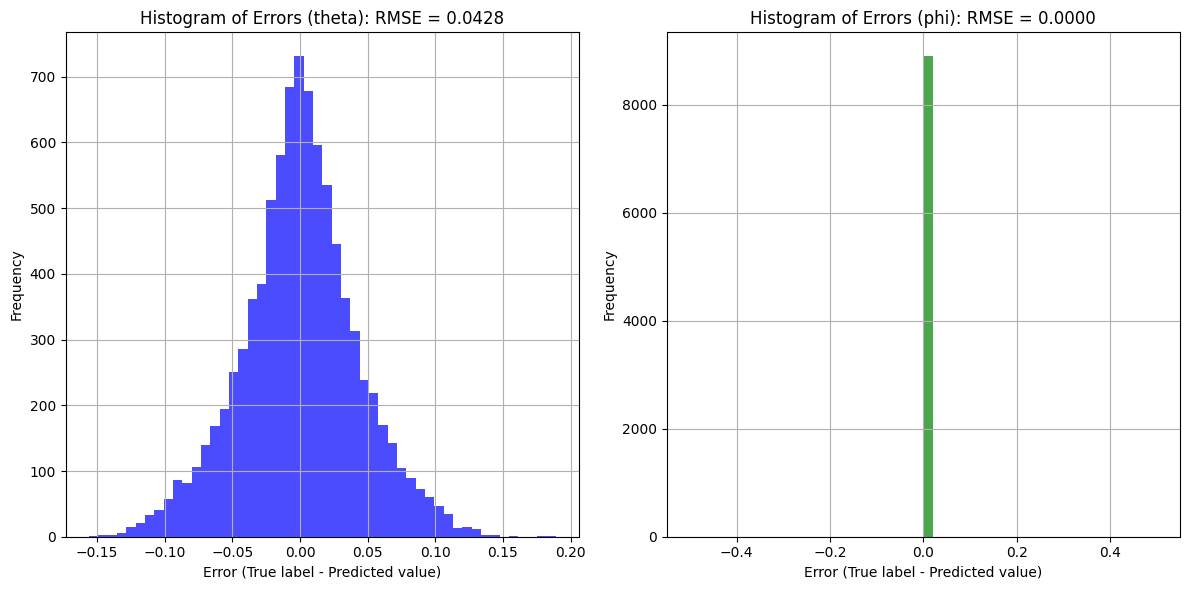

In [111]:
y_pred_theta = clf_theta.predict(
    X_events, num_iteration=clf_theta.best_iteration)
y_pred_phi = clf_phi.predict(X_events, num_iteration=clf_phi.best_iteration)

errors_theta = y_events[:, 0] - y_pred_theta
errors_phi = y_events[:, 1] - y_pred_phi


rmse_theta = mean_squared_error(y_events[:, 0], y_pred_theta, squared=False)
rmse_phi = mean_squared_error(y_events[:, 1], y_pred_phi, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(errors_theta, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram of Errors (theta): RMSE = {rmse_theta:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

# График для phi
plt.subplot(1, 2, 2)
plt.hist(errors_phi, bins=50, color='green', alpha=0.7)
plt.title(f'Histogram of Errors (phi): RMSE = {rmse_phi:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


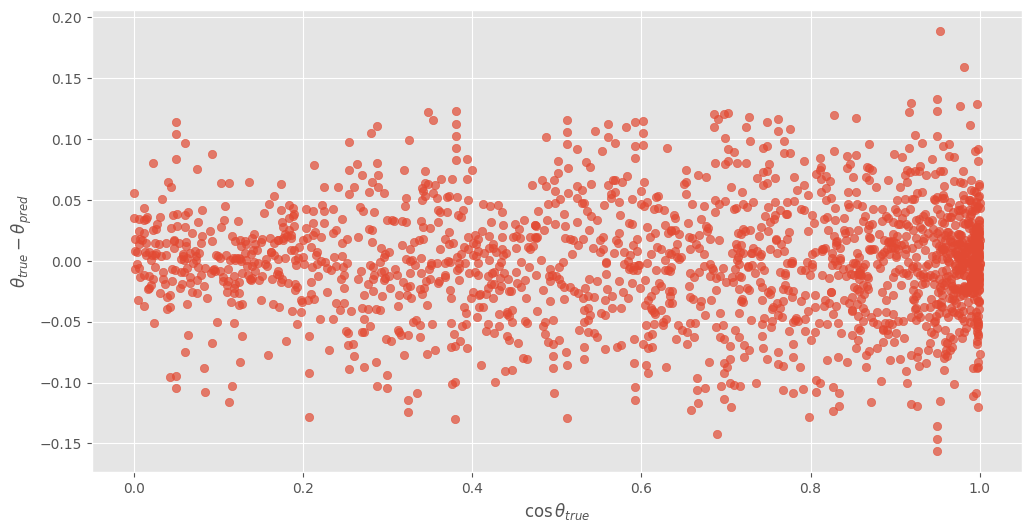

In [125]:
y_pred_theta = clf_theta.predict(
    X_test, num_iteration=clf_theta.best_iteration)

errors_theta = y_test[:, 0] - y_pred_theta


rmse_theta = mean_squared_error(y_test[:, 0], y_pred_theta, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

plt.figure(figsize=(12, 6))

plt.scatter(np.cos(np.radians(y_test[:, 0])),
            errors_theta, alpha=0.7)
plt.xlabel(r'$\cos{\theta_{true}}$')
plt.ylabel(r'$\theta_{true} - \theta_{pred}$')
# xticks = [0, np.pi/6, np.pi/3, np.pi/2]
# xtick_labels = [
#     r"$0$",
#     r"$\pi/6$",
#     r"$\pi/3$",
#     r"$\pi/2$"
# ]
# plt.xticks(xticks, xtick_labels)
plt.grid(True)
plt.savefig('plots/test_theta_diif.png')
plt.show()